### Exploratory Data Analysis

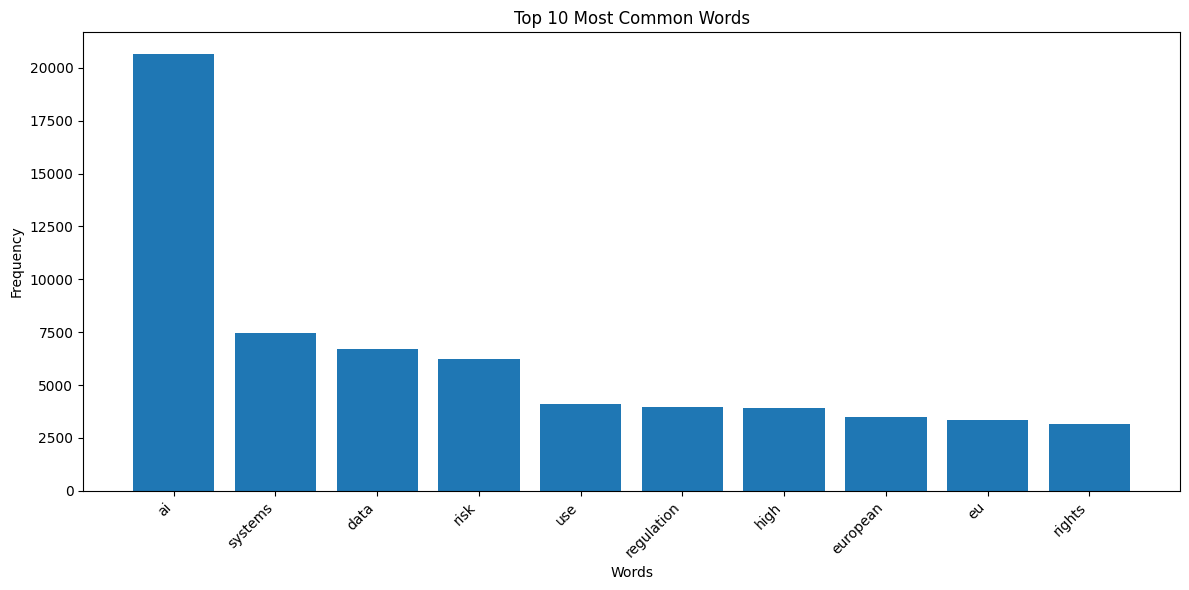

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Load cleaned English feedback dataset
feedback_en = pd.read_csv(
    "../data/processed/feedback_en.csv",
    encoding='utf-8',
    na_filter=False
)

# Vectorize text and get top 10 most common words
vectorizer = CountVectorizer(stop_words='english')
word_counts = vectorizer.fit_transform(feedback_en['text'])
word_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts.sum(axis=0).A1))
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10]

# Plot top 10 most common words
plt.figure(figsize=(12, 6))
plt.bar(*zip(*sorted_word_freq))
plt.title("Top 10 Most Common Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [3]:
 # Print top 10 most common words with their frequencies
print("Top 10 Most Common Words with Frequencies:")
for word, freq in sorted_word_freq:
    print(f"{word}: {freq}")

Top 10 Most Common Words with Frequencies:
ai: 20647
systems: 7459
data: 6683
risk: 6248
use: 4087
regulation: 3945
high: 3926
european: 3512
eu: 3339
rights: 3148


### 2. Identify Environmental Risk Mentions

In [4]:
import re
import nltk
from nltk.tokenize import sent_tokenize

# Ensure sentence tokenizer is downloaded
nltk.download('punkt')

# Define keywords related to environmental risks
env_keywords = [
    'climate', 'environmental', 'carbon', 'emission', 'energy', 'sustainability',
    'footprint'
]

def extract_env_sentences(text):
    if isinstance(text, str):
        sentences = sent_tokenize(text)
        env_sentences = [
            sentence for sentence in sentences
            if any(keyword in sentence.lower() for keyword in env_keywords)
        ]
        return ' '.join(env_sentences)
    return ''

# Apply the extraction function to each text entry
feedback_en['env_sentences'] = feedback_en['text'].apply(extract_env_sentences)
feedback_env = feedback_en[feedback_en['env_sentences'].str.strip() != '']
feedback_env.to_csv("../data/processed/feedback_environmental.csv", index=False)
print(f"Filtered dataset contains {len(feedback_env)} entries discussing environmental risks.")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/monserrat.lopez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Filtered dataset contains 122 entries discussing environmental risks.


### 3. Word Cloud for Environmental Feedback

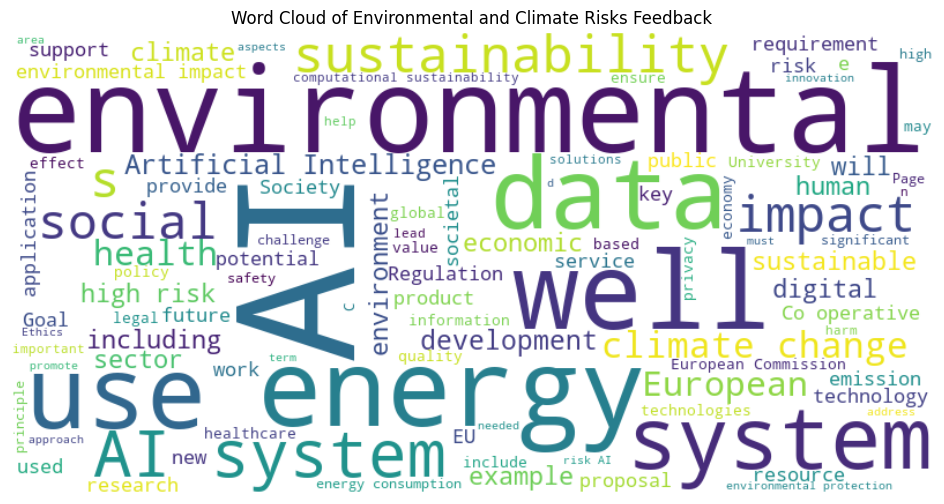

In [5]:
from wordcloud import WordCloud

# Combine all environmental sentences into one text
env_text = ' '.join(feedback_env['env_sentences'])
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=100
).generate(env_text)

# Display Word Cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Environmental and Climate Risks Feedback')
plt.show()
wordcloud.to_file("../output/wordcloud_environmental_raw.png")

/var/folders/xs/3lktsctn0vz644c75bfn0xn00000gp/T/ipykernel_63003/3324704612.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feedback_env['filtered_sentences'] = feedback_env['env_sentences'].apply(remove_custom_stopwords)


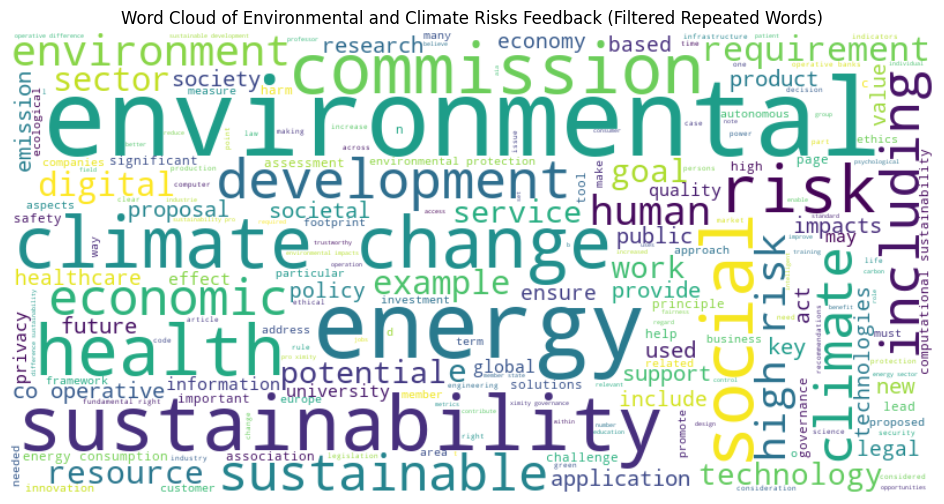

In [6]:
### Refine Environmental Keywords
custom_stopwords = [
    'ai', 'system', 'regulation', 'systems', 'impact', 'data', 'use', 'european', 'eu',
    'artificial', 'intelligence', 'well', 's', 'will'
]

def remove_custom_stopwords(text):
    if isinstance(text, str):
        tokens = re.findall(r'\b\w+\b', text.lower())
        tokens = [word for word in tokens if word not in custom_stopwords]
        return ' '.join(tokens)
    return ''

feedback_env['filtered_sentences'] = feedback_env['env_sentences'].apply(remove_custom_stopwords)
feedback_env.to_csv("../data/processed/feedback_environmental_filtered.csv", index=False)

# Generate refined Word Cloud
filtered_text = ' '.join(feedback_env['filtered_sentences'].dropna().astype(str))
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate(filtered_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Environmental and Climate Risks Feedback (Filtered Repeated Words)')
plt.show()
wordcloud.to_file("../output/wordcloud_environmental_filtered.png")

### 5. Tokenization and Word2Vec Training

In [8]:
from gensim.models import Word2Vec
import nltk

# Ensure stopwords are downloaded
nltk.download('stopwords')
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
feedback_env['tokenized_sentences'] = feedback_env['env_sentences'].apply(
    lambda x: [word for word in x.lower().split() if word not in stop_words and len(word) > 2]
)

sentences = feedback_env['tokenized_sentences'].tolist()
w2v_model = Word2Vec(
    sentences,
    vector_size=100,
    window=5,
    workers=4,
    epochs=10,
    min_count=5
)
w2v_model.save("../data/processed/word2vec_feedback_env.model")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/monserrat.lopez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/monserrat.lopez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/xs/3lktsctn0vz644c75bfn0xn00000gp/T/ipykernel_48145/1986161580.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feedback_env['tokenized_sentences'] = feedback_env['env_sentences'].apply(


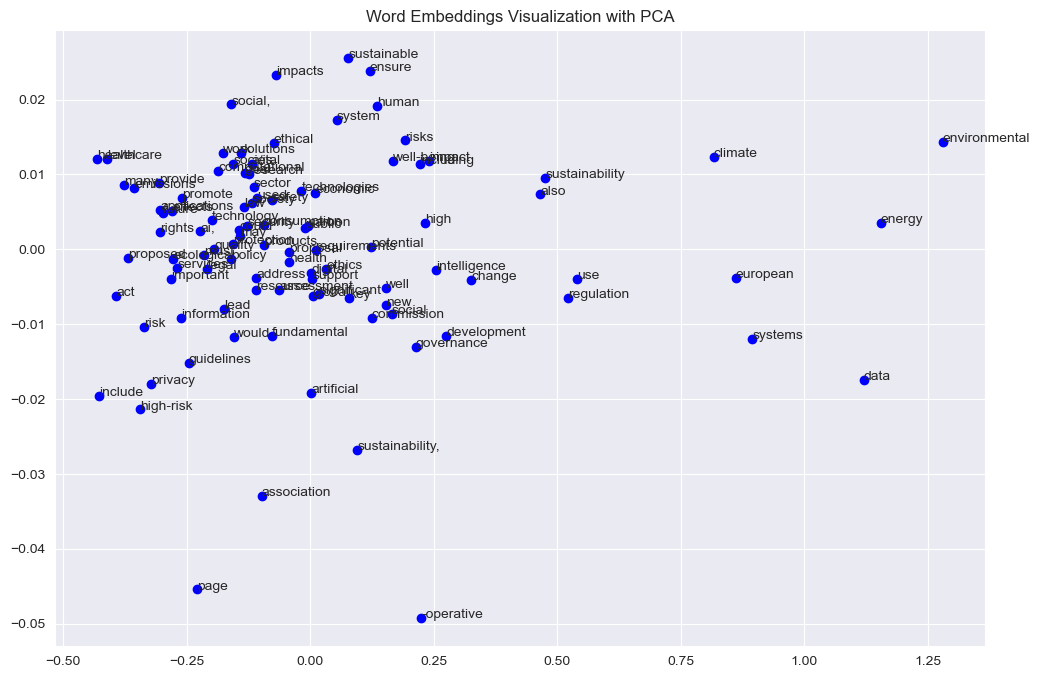

In [13]:
### Word Embeddings Visualization
from sklearn.decomposition import PCA

# Extract top 100 words from Word2Vec model
words = list(w2v_model.wv.index_to_key)[:100]
word_vectors = w2v_model.wv[words]

# Reduce dimensions using PCA
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(word_vectors)

# Plot word embeddings in 2D
plt.figure(figsize=(12, 8))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], color='blue')

for i, word in enumerate(words):
    plt.annotate(word, xy=(reduced_vectors[i, 0], reduced_vectors[i, 1]))

plt.title('Word Embeddings Visualization with PCA')
plt.show()

In [15]:
# Analyze relationships with the word 'energy'
if 'climate' in w2v_model.wv:
    similar_words = w2v_model.wv.most_similar('energy', topn=10)
    print("Top 10 words most similar to 'energy':")
    for word, similarity in similar_words:
        print(f"{word}: {similarity:.4f}")
else:
    print("'energy' is not in the Word2Vec vocabulary.")


Top 10 words most similar to 'energy':
environmental: 0.9996
data: 0.9996
systems: 0.9996
climate: 0.9995
european: 0.9995
regulation: 0.9995
also: 0.9995
development: 0.9994
potential: 0.9994
use: 0.9994
